<a href="https://colab.research.google.com/github/lajaaiti/NLP/blob/main/LSTM_Elvis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [2]:
# data import
data = pd.read_csv('dfElvis.csv')
data.head()

,Titre,Lyric
0,Can't Help Falling In Love,"Wise men say, only fools rush in\nBut I can't ..."
1,Suspicious Minds,We're caught in a trap\nI can't walk out\nBeca...
2,Always On My Mind,"Maybe I didn't treat you,\nQuite as good as I ..."
3,Love Me Tender,"Love me tender, love me sweet,\nNever let me g..."
4,My Way,And now the end is near\nAnd so I face the fin...


In [3]:
data['Number_of_words'] = data['Lyric'].apply(lambda x:len(str(x).split()))
data.head()

,Titre,Lyric,Number_of_words
0,Can't Help Falling In Love,"Wise men say, only fools rush in\nBut I can't ...",110
1,Suspicious Minds,We're caught in a trap\nI can't walk out\nBeca...,203
2,Always On My Mind,"Maybe I didn't treat you,\nQuite as good as I ...",159
3,Love Me Tender,"Love me tender, love me sweet,\nNever let me g...",125
4,My Way,And now the end is near\nAnd so I face the fin...,249


In [4]:
data['Number_of_words'].describe()

count    747.000000
mean     154.759036
std       66.081887
min       17.000000
25%      106.000000
50%      149.000000
75%      192.000000
max      452.000000
Name: Number_of_words, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

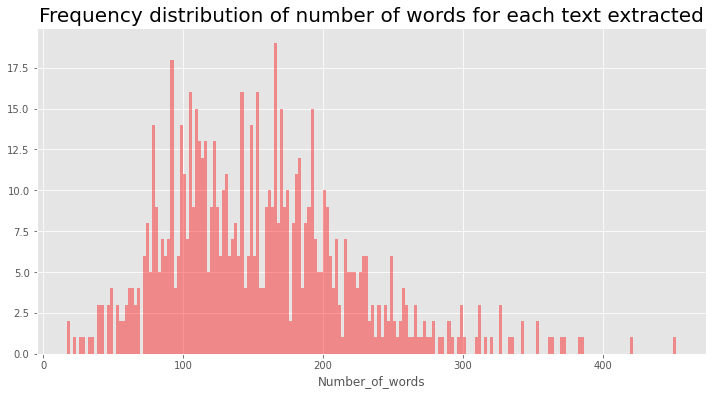

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

In [6]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(data['Lyric'].astype(str))
tokenized_sentences[0]

[434,
 646,
 74,
 99,
 1358,
 983,
 9,
 24,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3,
 299,
 2,
 176,
 123,
 16,
 13,
 4,
 723,
 33,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3,
 35,
 4,
 672,
 1670,
 673,
 6,
 1,
 317,
 177,
 22,
 16,
 390,
 2662,
 62,
 820,
 6,
 13,
 77,
 8,
 109,
 77,
 8,
 228,
 97,
 104,
 17,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3,
 35,
 4,
 672,
 1670,
 673,
 6,
 1,
 317,
 177,
 22,
 16,
 390,
 2662,
 62,
 820,
 6,
 13,
 77,
 8,
 109,
 77,
 8,
 228,
 97,
 104,
 17,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3,
 17,
 2,
 67,
 231,
 496,
 9,
 11,
 27,
 3]

In [7]:
#Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [8]:
input_sequences[:10]

array([[  0,   0,   0, ...,   0, 434, 646],
       [  0,   0,   0, ..., 434, 646,  74],
       [  0,   0,   0, ..., 646,  74,  99],
       ...,
       [  0,   0,   0, ...,   9,  24,   2],
       [  0,   0,   0, ...,  24,   2,  67],
       [  0,   0,   0, ...,   2,  67, 231]], dtype=int32)

In [9]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [10]:
# create model
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(240)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, epochs=40, verbose=1, callbacks=[earlystop])

Epoch 1/40
3596/3596 [==============================] - 202s 54ms/step - loss: 5.9584 - accuracy: 0.0739
Epoch 2/40
3596/3596 [==============================] - 191s 53ms/step - loss: 5.1275 - accuracy: 0.1348
Epoch 3/40
3596/3596 [==============================] - 194s 54ms/step - loss: 4.5117 - accuracy: 0.1903
Epoch 4/40
3596/3596 [==============================] - 191s 53ms/step - loss: 4.0103 - accuracy: 0.2448
Epoch 5/40
3596/3596 [==============================] - 189s 53ms/step - loss: 3.5974 - accuracy: 0.2972
Epoch 6/40
3596/3596 [==============================] - 188s 52ms/step - loss: 3.2599 - accuracy: 0.3431
Epoch 7/40
3596/3596 [==============================] - 188s 52ms/step - loss: 2.9817 - accuracy: 0.3852
Epoch 8/40
3596/3596 [==============================] - 188s 52ms/step - loss: 2.7449 - accuracy: 0.4213
Epoch 9/40
3596/3596 [==============================] - 187s 52ms/step - loss: 2.5520 - accuracy: 0.4535
Epoch 10/40
3596/3596 [==============================] 

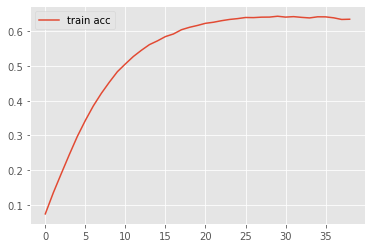

<Figure size 432x288 with 0 Axes>

In [11]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [14]:
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted =np.argmax(predicted,axis=1)
        #predicted = np.round(predicted).astype(int)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [17]:
complete_this_song("the sky is blue", 50)

'the sky is blue i long to be true i know the best i finally ever never ever ever never never never never never never never never never never never ever never never never ever ever never never never ever never never never ever never never never ever ever never never ever ever never'

In [16]:
# save model
model.save('Elvis_generator_bis.h5')